# SIR parameter learning using LM-BFGS for exact target

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - \gamma I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy           import logical_and, where, allclose, full, clip
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate   import CubicHermiteSpline
from scipy.sparse.linalg import LinearOperator
from numpy.polynomial.chebyshev import chebpts1

Initial conditions:

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-3
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0
# Rates
α = β, γ = 0.03, 0.6
m = 0

In [5]:
ℛ_ₒ = (β * n)/(γ + m)
print(ℛ_ₒ)

10.0


## Generation of $\widehat \rho$

We are going to generate one choice for $\widehat\rho$. The first, labelled $\widehat\rho_{\mathsf e}$ is just three curves that satisfy the initial conditions.

In [6]:
T  = 10                            # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [7]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [8]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y
ρ̂ = ρ.copy()

# Create an abstract interpolator for state
ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

In [9]:
ρ̄ₙ = ρ̄
ρ̄ₑ = ρ̄

ρ̂ₙ = ρ̂
ρ̂ₑ = ρ̂

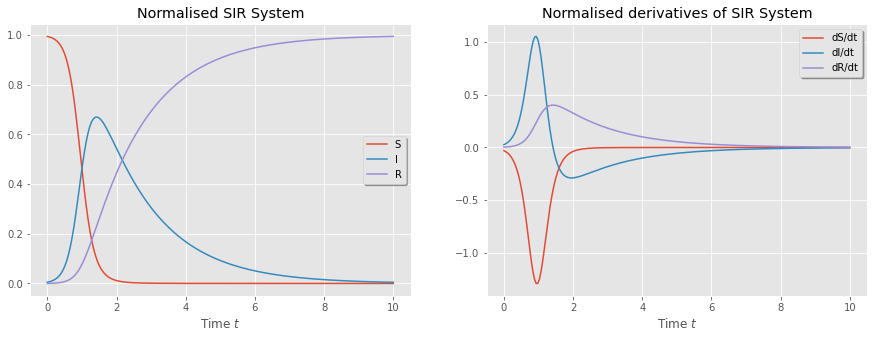

In [10]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [11]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄ₑ(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}_{\mathsf n}$:

In [12]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,ρ̄ₙ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 50 function evaluations.


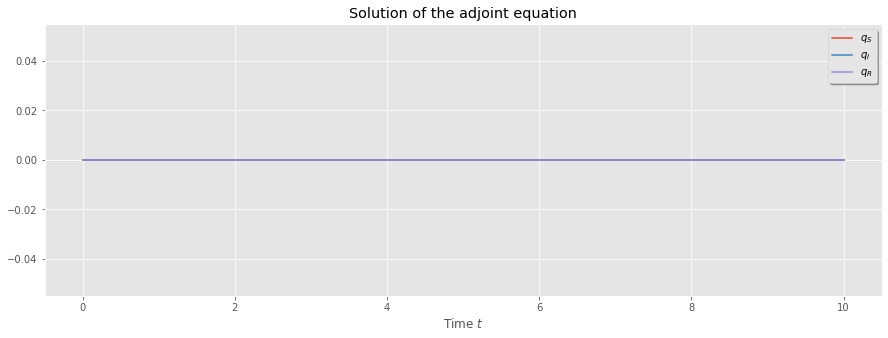

In [13]:
# Plot adjoint curves
plt.figure(figsize=(15,5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t.
\end{align}

In [14]:
def Objective(ρ,ρ̂):    return 0.5 * simpson((ρ-ρ̂)**2,x=Tₑ).sum()

In [15]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [16]:
print('As an example, the distance between ρ̂ and ρ̂ₑ is {0:.4f}.'.format( Objective(ρ̂,ρ̂ₑ) ))

As an example, the distance between ρ̂ and ρ̂ₑ is 0.0000.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t
\end{align}

In [17]:
q = solₛ.y[:,::-1]

In [18]:
df = asarray([simpson(ρ̂ₙ[0]*ρ̂ₙ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ̂ₙ[1] * (q[2]-q[1]), x=Tₑ)])
display(df.tolist())

[0.0, 0.0]

# Surfaces

For computational practicity, we will store the computed state and adjoint variables during the evaluation of the objective and derivatives.

In [19]:
global ρ, q
ρ, q = empty((3, Tₑ.size), np.float64), empty((3, Tₑ.size), np.float64)

In [20]:
def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ̂ = ρ_sol.y
    f = Objective(ρ̂,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0

    return f
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ̂ = ρ_sol.y
    f = Objective(ρ̂,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ̂, asarray(SIR(0,ρ̂,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q̂ = q_sol.y[:,::-1]

    # Compute derivative
    dF = asarray([simpson(ρ̂[0]*ρ̂[1] * (q̂[1]-q̂[0]), x=Tₑ), simpson(ρ̂[1] * (q̂[2]-q̂[1]), x=Tₑ)])
    dF /= (n**2) if scaling else 1.0

    return f, dF

---

In [21]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.007,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [22]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.013002574492017794; (β,γ): 0.02686 0.6276


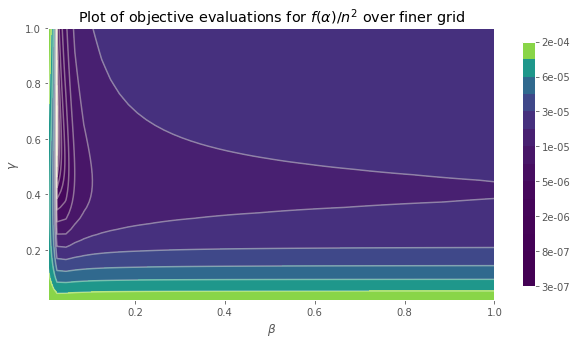

In [23]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

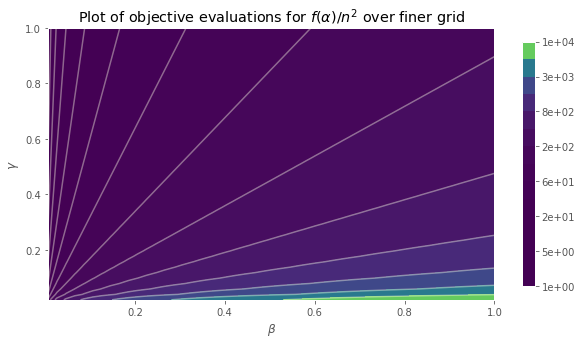

In [24]:
# Contour plot basic reproduction number
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = np.logspace( np.log( Reprod.min() ), np.log( Reprod.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Reprod, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $f$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

Following the work of Yuan et al (2014), assuming 0 and $1$ as lower and upper bounds, respectively,
we introduce the quantity $x_k := \min\big\{\beta_k, c \|\nabla f(x_k)\|\big\} $, where $\beta_k$ and $c$ are positive constants such that $ 0 < \beta_k < \frac{1}{2} $, and define the strongly-active and inactive index sets by
\begin{align}
    A_k &:= \big\{ i \in \{1, \dots,n\}: \, x_{k,i} 
            \leq \xi_k \lor x_{k,i} \geq 1 -  \xi_k \big\},	
            \label{ec:active_set}
    \tag{1.a}
    \\
    I_k &:= \{1, \dots,n\} \setminus A_k = 
            \big\{ i \in \{1, \dots,n\}: \, \xi_k < x_{k,i} < 1 -  \xi_k \big\},	\label{ec:inactive_set}
    \tag{1.b}
\end{align}
respectively, where $x_{k,i}$ is the $i$-th element of $x_k$.
Now, suppose the current trust region radius is $\widehat\Delta >0$, with its maximum value $\Delta_{\max} > 0$, and let $\kappa > 0$. We can obtain a search direction at step $x_k$ as follows:

* **Projected gradient direction:** Compute
\begin{equation}\label{ec:proy_grad}
d^G_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{1 , \,x_k - \dfrac{\widehat\Delta}{\Delta_{\max}}  \kappa_k \nabla f(x_k) \right\} \right\} - x_k.
\tag{PG}
\end{equation}

* **Projected trust-region direction:** We look for a direction $d^{\text{tr}}_{*k} (\widehat\Delta)$ defined for each index of the sets $A_k$ and $I_k$, respectively.
We begin with $A_k$, for which we let $v_k^{A_k}$ be the subvector
\begin{equation}
    v_k^{A_k} :=
    \begin{cases}
        x_{k,i}     & \text{if } x_{k,i} \leq \xi_k,  \\
        1 - x_{k,i} & \text{if } x_{k,i} \geq 1 - \xi_{k}.
    \end{cases}
\end{equation}
Then we define the subvector
\begin{equation}
    d^{A_k}_{*k} (\widehat\Delta)  := \min \left\{ 1, \dfrac{\widehat\Delta}{\|v_k^{A_k}\|} \right\} v_k^{A_k}.
    \tag{SV}
\end{equation}
For the inactive set $I_k$ we solve a reduced trust-region subproblem. Here, let $B_k$ be partitioned into two submatrices $B_k^{A_k} $ and $B_k^{I_k} $, obtained by taking columns of $B_k$ indexed by $A_k$ and $I_k$, respectively. Let $ d^{I_k}_{*k} (\widehat\Delta) $ be a solution of the following TR–subproblem
\begin{equation} \label{ec:subvector_inactive}
\begin{aligned}
        \min \;\, & d^\top \Big[ \big(B_k^{I_k}\big)^\top \big( \nabla f(x_k) + B_k^{A_k} d^{A_k}_{*k}  \big) \Big] + \dfrac{1}{2} d^\top \big(B_k^{I_k}\big)^\top B_k^{I_k} d\\
\text{s.t. } & \|d\| \leq \widehat\Delta.
\end{aligned}
\tag{TR}
\end{equation}
The projected trust-region direction is then defined as
\begin{equation}
    d^{\text{tr}}_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{ 1, \, x_k + \begin{pmatrix} d^{A_k}_{*k} (\widehat\Delta) \\ d^{I_k}_{*k} (\widehat\Delta)  \end{pmatrix}\right\} \right\} - x_k.
\end{equation}
Since this direction may not be a descent direction for $f$ for far iterates, we use a convex combination with the gradient direction as follows.

* **Search direction:** Let
\begin{equation}
d_{* k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta),
	\end{equation}
	where $t_{*k}$  is a solution of the following one-dimensional problem
	\begin{equation}\label{ec:search_dir_one_dim}
		\min_{t \in [0,1]} f\big( x_k + t d_{*k}^G(\widehat\Delta) + (1- t) d^{\text{tr}}_{*k} (\widehat\Delta) \big).
        \tag{SD}
	\end{equation}

<div class="alert alert-block alert-warning">
Yuan, G., Wei, Z. & Zhang, M. An active-set projected trust region algorithm for box constrained optimization problems. J Syst Sci Complex 28, 1128–1147 (2015). https://doi.org/10.1007/s11424-014-2199-5
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Trust-Region Algorithm with L-BFGS Update</h2>
<ol>
<li>Choose \(x_0 \) and a symmetric positive definite matrix \(H_0\). Let constants satisfy \(0 < \beta_0 < \frac{1}{2} \), \(c>0\), \(0 < \nu_1 < 1 < \nu_2\), \(0<\tau_1<\tau_2<1\), \(\upsilon \in (0,1)\), \(\omega \in \mathbb{R}\), \(\Delta_0 >0\), and \( \Delta_{\max} > \Delta_{\min} > 0\). Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\)
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Let \(\Delta_k := \min\big\{ \Delta_{\max}, \max\{\Delta_{\min}, \Delta_k\} \big\}\) and \(\widetilde\Delta = \Delta_k\).
</li>
    
<li> Determine index sets \(A_k\) and \(I_k\) by (1.a) and (1.b).
</li>
    
<li> Find \(d_{*k}^{\text{tr}} (\widetilde\Delta)\) by determining \(d_{*k}^{A_k} (\widetilde\Delta)\) and \(d_{*k}^{I_k} (\widetilde\Delta)\) as in (SV) and (TR).
</li>
    
<li> Set
    \[
        \kappa_k := \min\left\{ 1, \dfrac{\Delta_{\max}}{\big\| \nabla j(x_k) \big\|}, \dfrac{\omega}{\big\| \nabla j(x_k) \big\|} \right\}.
    \]
</li>


<li>Compute \( d_{*k}^G(\widetilde\Delta)\) and \(t_{*k}\) as in (PG) and (SD), respectively. Let
    \[
        d_{*k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta).
    \]
</li>
    
    
<li>Compute
    \[
        r_{*k} := \dfrac{ j(x_k + d_{*k}) - j(x_k)}{ \nabla j(x_k)^\top d_{*k} (\widehat\Delta) + \frac{1}{2} \, d_{*k} (\widehat\Delta)^\top B_k d_{*k} (\widehat\Delta)}
    \]
</li>
    
    
<li> \(\mathbf{If}\) \(j(x_k) - j \big(x_k + d_{*k} (\widehat\Delta) \big) \geq -\upsilon \nabla j (x_k)^\top d^G_{*k} (\widehat\Delta)\) and \(r_{*k} \geq \tau_1\) hold \(\mathbf{then}\)
</li>
    
<ol>
    <li> Let \(q_k := d_{*k}\), \(x_{k+1} := x_k + d_{*k}\), \(\beta_k = \widehat\Delta \), and
        \[
            \Delta_{k+1} :=
            \begin{cases}
                \widehat\Delta & \text{if } \tau_1 < r_{*k} < \tau_2,
                \\
                \nu_2 \widehat\Delta & \text{if } r_{*k} \geq \tau_2.
            \end{cases}
        \]
    </li>
    <li> Let \(\widehat m := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
    <li> Let \(k = k+1\) and return to step A. </li>
</ol>
    

    
<li> \(\mathbf{else}\) </li>
<ol>    
    <li>Let \(\widehat\Delta = \tau_1 \widehat\Delta\). </li>
<li> Return to step C.</li>
</ol>
</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

One aspect of the BFGS method is that each update is positive definite. As the limited memory formula for $B_k$ can also be stated as
\begin{equation}
	B_k = V_k^\top H_k V_k + p_k q_k q_k^\top,
\end{equation}
with $ p_k := \big( q_k^\top d_k \big)^{-1}$ and $V_k :=  I_n - p_k d_k q_k^\top$. Thus, we can guarantee positive definiteness using Powell's method in which $d_k$ is redefined as
\begin{equation}
	d_k :=
	\begin{cases}
		d_k		& \text{if } q_k^\top d_k \geq 0.2 q_k^\top B_k d_k,
		\\
		\alpha_k d_k + (1-\alpha_k) B_k q_k & \text{otherwise},
	\end{cases}
\end{equation}
where $\alpha_k := \frac{0.8 q_k^\top B_k q_k}{q_k^\top B_k q_k - q_k^\top d_k}$. If the updated $q_k^\top d_k$ is too close to zero, to maintain numerical stability, the limited memory matrix is not updated.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

In [25]:
β, γ = α = rng(0).uniform(0,1,2)              # Initial point

In [26]:
dim = 2            # dimension of the parameter to optimise 

In [27]:
'''Reserve memory'''
cLM   = 1
S     = append([1], zeros(dim-1)).reshape(dim,1);                        Y = S.copy()
SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)

In [28]:
'''Functions needed for LM operations'''
def Limited():
    def B_eval(W,MI,dk):
        db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
    def BA_eval(W,MI,Uk,dUk):
        db = zeros(dim, dtype='float')
        db[Uk] = dUk;            db *= θᵪ;        db -= W.dot(MI.dot(W[Uk,:].T.dot(dUk)));     return db
    def BAT_eval(W,MI,Uk,dUk):
        db = dUk[Uk].copy();     db *= θᵪ;        db -= W[Uk,:].dot(MI.T.dot(W.T.dot(dUk)))
        return db
    def H_eval(WH,MH,dk):
        db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
    def HA_eval(WH,MH,Uk,dUk):
        db = zeros(dim, dtype='float');   db[Uk] = dUk;    db /= θᵪ;    db += WH.dot(MH.dot(WH[Uk,:].T.dot(dUk)))
        return db
    def HAT_eval(WH,MH,Uk,dUk):
        db = dUk[Uk].copy();     db /= θᵪ;     db += WH[Uk,:].dot(MH.T.dot(WH.T.dot(dUk)));   return db
    return B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval

A Limited Memory BFGS method is used. The matrices will be constantly updated.

In [29]:
def LBFGS(S,Y,SY, θ):
    W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
    MI  = inv(MM)
    WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
    MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
    return MI, MH, W, WH
def LSR1(S,Y,SY, θ):
    W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
    while np.linalg.det(MM) == 0.0:
        θ *= 0.5
        W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
    MI = inv(MM)
    WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
    MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
    return MI, MH, W, WH

## Algorithm

In [30]:
''' Create structures to store information from iterates '''
save_iter = True            # Do we store information for every iteration?
if save_iter:
    ei_keys = ['it', 'obj', 'time', 'β', 'γ', 'df_β', 'df_γ', 't_k', 'norms']
    ei_norm = ['ℓ_1', 'ℓ_2', 'max', 'min']
    
    every_iter = {a:[] for a in ei_keys}
    every_iter['norms'] = {a:[] for a in ei_norm}

    
save_critical = True        # Do we store information for every "critical" iteration?
critical = 2                # An iteration is critical after some iterations
if save_critical:
    ec_keys = ['it', 'obj', 'time', '|df|_2', '|df|_max']

    every_critical = {a:[] for a in ec_keys}

In [31]:
xₖ = asarray(α).copy()      # IMPORTANT to avoid clash with the α defined below (!!!)

All parameters involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.

In [32]:
''' Setting TR parameters '''
αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
bᵪ = 1.0                         # Box upper bound
σᵪ = 0.01                        # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
ηᵪ = 0.9                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
δᵪ = 0.99 * 0.5                  # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
cᵪ = 1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
pᵪ = 0.35                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9]
mᵪ = 5                           # Memory size for LM
θᵪ = 1.0                         # Initial weight for basic Hessian approximation
Δᵪ = [1.0, 2.0, 1e-6, 1.0]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

''' Additional tolerances '''
εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
εᵪ_Ha    = 5e-13                 # Absolute Himmeblau criteria
εᵪ_Hb    = 1e-13                 # Relative Himmeblau criteria

In [33]:
''' Initial iteration (xₒ, fₒ, dfₒ) '''
fₖ, dfₖ  = obj_eval(xₖ)
Obj_Res = [];              Obj_Res.append(fₖ.tolist())
''' Initial iteration counter and maximum number of iterations '''
kᵪ      = 0;
Max_It  = 100

In [34]:
Method = 'BFGS'

In [35]:
# Control if TR is increased for achieving a larger search
#grow   = False           # Activates growth to expand search
#f_grow = array(1e+10)    # Limits growth size

timed = 0.0              # Clock

''' Run algorithm for the given settings '''
for kᵪ in range(Max_It):
    
    # Print header of table
    if kᵪ == 0:
        print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^11s}|{5:^11s}|'.format('#','β', 'γ', 'f(α)',
                                                                    'ᵣ‖∇f(α)‖2','ᵣ‖∇f(α)‖∞'), end='')
        print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','ᵣ‖d‖2', 'Time'))

        print('–'*110)
        
        # Report initial iteration info
        if save_iter:
            every_iter['it'].append( kᵪ-1 )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( xₖ[0] )
            every_iter['γ'].append( xₖ[1] )
            every_iter['df_β'].append( dfₖ[0] )
            every_iter['df_γ'].append( dfₖ[1] )
            every_iter['t_k'].append( 0.0 )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
            every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
            every_iter['norms']['min'].append( abs(dfₖ).min() )
        if kᵪ % critical == 0:
            every_critical['it'].append( kᵪ-1 )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
            every_critical['|df|_max'].append( norm(dfₖ,np.inf) )
            
        print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ-1, xₖ[0], xₖ[1], fₖ,
                                                            norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)) )
    
    # *************** #
    # Stationarity test
    if np.all(dfₖ[xₖ == 0.0] >= 0.0) & np.all(dfₖ[xₖ == 1] <= 0.0) & allclose(dfₖ[logical_and(xₖ>0.0, xₖ<1)], 0.0):
        print('Optimality reached.')
        break
        
    it_time = time.time()                                # Clock
    
    # *************** #
    # 1. TR radii update
    Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
    Δᵪ[-1] = Δᵪ[0]                                       # Δ̂
    
    # *************** #
    # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
    ξᵪ = min(δᵪ, cᵪ * norm(dfₖ) ** pᵪ )                  # Estimate of inactive region (12)
    Iₖ = where( (xₖ > ξᵪ) & (xₖ < bᵪ-ξᵪ) )[0]             # Inactive set (13)
    Aₖ = where( (xₖ <= ξᵪ) + (xₖ >= bᵪ-ξᵪ) )[0]            # Active set (13)
    
    # *************** #
    # 3. Trust-Region Subproblem
    
    # ––––––––– #
    # Limited memory matrix
    if Method == 'BFGS':
                 MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
    else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
    #
    B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()
    
    # ––––––––– #
    # Gradient scaling
    γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
    #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))
    
    # ––––––––– #
    # Subvector of estimated active elements
    vₖ      = full(dim, np.nan)                           # Initialise
    Aˡᵪ, Aᵘᵪ = (xₖ <= ξᵪ), (xₖ >= bᵪ - ξᵪ)                 # Collect active indices
    vₖ[Aˡᵪ] = xₖ[Aˡᵪ];    vₖ[Aᵘᵪ] = bᵪ - xₖ[Aᵘᵪ]           # Lower and upper sides
    vAₖ     = vₖ[Aₖ]                                       # Extract info
    
    # ––––––––– #
    # Reserve memory for TR direction
    dTRₖ = ones(dim)
    
    
    # ––––––––– #
    # TR iteration
    kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
    while 1 != 2:
        # ///// #
        # 3.a Projected Gradient Direction
        #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
        wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
        dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ
        
        # ///// #
        # Active direction [prevent empty division]
        wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
        dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])
        
        # ///// #
        # 3.b Reduced TR subproblem in inactive set
        if Iₖ.size > 0:
            #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
            #dd[Ak] += dAk                                   # considered and comment c below.
            
            BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ)             # Linear part
            #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ)                                  # If Aₖ is not to be considered
            
            def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )    # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
            BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
            def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))         # Subproblem objective
            def gv(d):    return  BBdₐ + BB(d)                             # Gradient of subproblem
            
            A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
            B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ[Iₖ], A_guess)    # Constrained guess
            #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
            #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])
            
            InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                       bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200})
            dIₖ = InactiveSubProb.x
        else:
            dIₖ = array([])
        
        # ///// #
        # Projected TR Direction [from LM and active sets]
        dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
        dTRₖ = proj(xₖ + dTRₖ) - xₖ                        # Projected direction (18)
        
        
        # *************** #
        # 4. Search direction
        # ///// #
        if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
        else:
            # ** Optimize only knowing objective ** #
            #def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
            # ** Optimize with gradient information ** #
            def a_fun(t):
                ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                return ob, array( der.dot(dGₖ - dTRₖ) )
            
            # Optimise one dimensional convex combination between the obtained directions
            OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', jac = True, 
                                        bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 10})
            
            # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
            #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
            if OneDimensionalCC.status != 0:
                print('\033[1;31;47m * \x1b[0m', end = ' ')    
            tₖ = OneDimensionalCC.x.item()
        
        # ///// #
        # The final direction is the best linear combination of the projected gradient with the LM direction
        dₖ = tₖ * dGₖ + (1.0-tₖ) * dTRₖ
        
        
        # *************** #
        # 5. Test the Search Direction
        # ///// #
        Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                      # Evaluate direction to be tested
        rₖ = (Tfₖ - fₖ)/( Tdfₖ.dot(dₖ) + 0.5 * dₖ.dot( B_eval(W,MI,dₖ) ) )        # TR reduction ratio
        
        # Check line search condition
        ArmijoGoldstein = (fₖ + σᵪ * dfₖ.dot(dGₖ) >= Tfₖ)
        # Test if reduction ratio is accepted
        AcceptReduction = (rₖ >= ρᵪ[0])
        
        # If both conditions are satisfied, then accept step and continue to the next iteration
        if AcceptReduction and ArmijoGoldstein:
            if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
            break
        else:
            # TR radius is decreased
            if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
            # Update counter
            kᵢₙₙₑᵣ += 1
            # Decrease TR radius 
            Δᵪ[-1] *= αᵪ[0]
            # Print updated radius
            print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
            # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
            if Δᵪ[-1] < Δᵪ[2]:
                print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                break
            
    # ––––––––– #
    # TR radius stopping criteria
    if Δᵪ[-1] < Δᵪ[2]:
        print('\033[10;42;1m  TR-min  \033[10;42;1m')
        break
        
    # ––––––––– #
    # Updating info
    sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
    yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
    xₖ += dₖ                                              # Store xₖ + dₖ
    
    # ––––––––– #
    # Himmeblau stopping criteria
    if abs(fₖ) > εᵪ_HCond:
        if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
            print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
            fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
            break
    else:
        if abs(fₖ - Tfₖ) < εᵪ_Ha:
            print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
            fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
            break
        
    # ––––––––– #
    # Updating info
    fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
    yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
    #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]
    
    # ––––––––– #
    # Test for TR expansion
    if rₖ >= ρᵪ[1]:
        Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
    else:
        Δᵪ[0] = Δᵪ[-1]
    
    
    # ––––––––– #
    # Update of LM info
    ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]
    
    # Powell correction
    if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
        # print('\033[0;34;48m [P] \x1b[0m')
        əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
        yₖ *= əᵪ
        yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)
    
    # Add LM updates if curvature sₖᵀyₖ is not too small
    if ϕᵪ[0] > εᵪ_LM:
        # print('\033[5;34;46m [C] \x1b[0m')
        cLM = min(S.shape[1], mᵪ)            # Current LM size
        if cLM < mᵪ:                         # If size is small, add column with secant information
            S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
            cLM  += 1 
            SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
        else:                                # If size is too large, drop first column
            S = append(S[:,1:], sₖ[:,None], axis=1)
            Y = append(Y[:,1:], yₖ[:,None], axis=1)
            
        #print( norm(yₖ)/norm(sₖ) )           # This quantity can be of interest
    
    # If curvature is too small, we can reset the LM objects
    if ϕᵪ[1] < εᵪ_LM:
        # print('\033[7;34;48m [R] \x1b[0m')
        cLM   = 1
        S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
        SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)

    
    # *************** #
    # Measure time up to this point!
    end = time.time()
    timed += end - it_time
    
    # Report current status
    if save_iter:
        every_iter['it'].append( kᵪ )
        every_iter['obj'].append( fₖ )
        every_iter['time'].append( timed )
        every_iter['β'].append( xₖ[0] )
        every_iter['γ'].append( xₖ[1] )
        every_iter['df_β'].append( dfₖ[0] )
        every_iter['df_γ'].append( dfₖ[1] )
        every_iter['t_k'].append( tₖ )
        # Store norms of gradient
        every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
        every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
        every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
        every_iter['norms']['min'].append( abs(dfₖ).min() )
    if kᵪ % critical == 0:
        every_critical['it'].append( kᵪ )
        every_critical['obj'].append( fₖ )
        every_critical['time'].append( timed )
        every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
        every_critical['|df|_max'].append( norm(dfₖ,np.inf) )
    
    
    # Store objective [might not be needed anymore but it's handy]
    Obj_Res.append(fₖ.tolist())
    
    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], fₖ,
                                                            norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)), end='')
    print('{0:^5d}|{1:^5d}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size, Iₖ.size,tₖ,norm(dₖ)/(dim**0.5), timed))
    
    
    if kᵪ == Max_It:
        print('\033[10;41;1m  Maxiter  \033[10;41;1m')
        
# Measure final time
end = time.time();    timed += end - it_time
print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))

  #  |     β     |     γ     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 6.370e-01 | 2.698e-01 | 8.047e-01 | 1.821e+00 | 2.575e+00 |
 TR-radius:  5.000e-01  2.500e-01 
  0  | 6.345e-01 | 3.823e-01 | 6.692e-01 | 2.105e-01 | 2.898e-01 |  2  |  0  |   1    | 7.955e-02 |   0.391   
 TR-radius:  2.500e-01  1.250e-01  6.250e-02  3.125e-02  1.562e-02  7.812e-03 
  1  | 6.399e-01 | 3.879e-01 | 6.681e-01 | 1.709e-01 | 2.324e-01 |  2  |  0  |   0    | 5.524e-03 |   2.74    
  2  | 6.505e-01 | 3.994e-01 | 6.667e-01 | 1.003e-01 | 1.261e-01 |  2  |  0  |   0    | 1.105e-02 |   2.84    
 TR-radius:  1.562e-02  7.812e-03  3.906e-03 
  3  | 6.531e-01 | 4.023e-01 | 6.666e-01 | 8.436e-02 | 1.008e-01 |  2  |  0  |   0    | 2.762e-03 |   3.73    
  4  | 6.570e-01 | 4.070e-01 | 6.664e-01 | 6.303e-02 | 6.386e-02 |  2  |  0  | 0.225  | 4.303e-03 |   3.85 

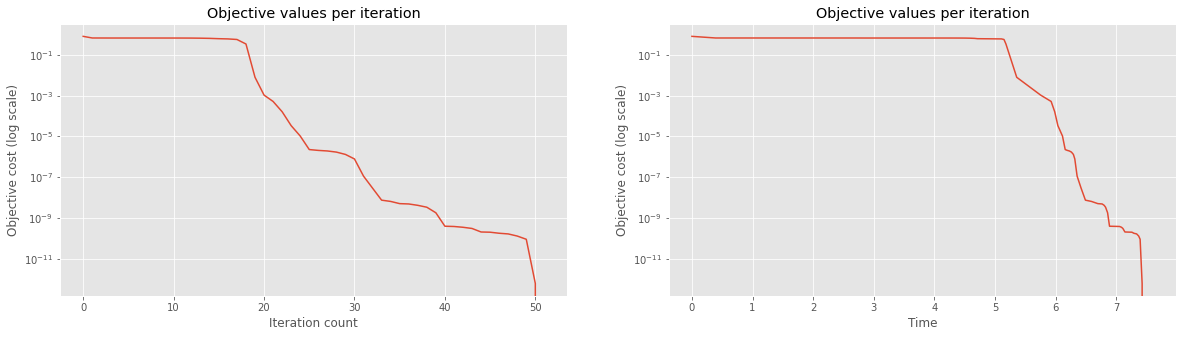

In [36]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [37]:
df_critical = pd.DataFrame.from_dict(every_critical)
#df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
#df_critical.to_excel(out_folder+'Critical.xlsx')
#display(df_critical)

# If we want this table in LaTeX format run:
#print(df_critical.to_latex(index=False))

In [38]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
df_every.to_pickle('Outputs/Exact – LMBFGS - Every.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,β,γ,df_β,df_γ,t_k,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
47,46,2.6544453107904417e-10,7.336096,0.03,0.599984,0.000133,-0.000031,1.000000,0.000082,0.000097,0.000133,0.000031
48,47,2.3102349522305225e-10,7.369650,0.03,0.599985,-0.000002,-0.000030,0.999864,0.000016,0.000021,0.000030,0.000002
49,48,1.9228249014981917e-10,7.393346,0.03,0.599987,0.000256,-0.000025,1.000000,0.000140,0.000182,0.000256,0.000025
50,49,1.0464764499279939e-10,7.426414,0.03,0.599990,-0.000008,-0.000020,0.998939,0.000014,0.000015,0.000020,0.000008
51,50,1.0404906482486243e-10,7.607165,0.03,0.599990,0.000029,-0.000020,1.000000,0.000024,0.000025,0.000029,0.000020


In [39]:
ᾱ = xₖ.copy()

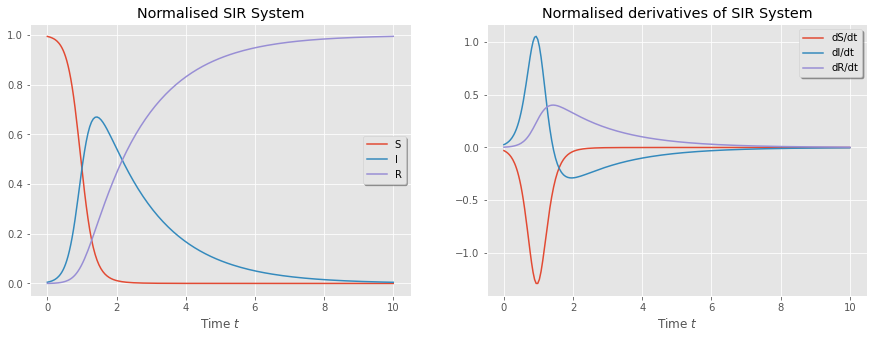

In [40]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, ᾱ[0], ᾱ[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

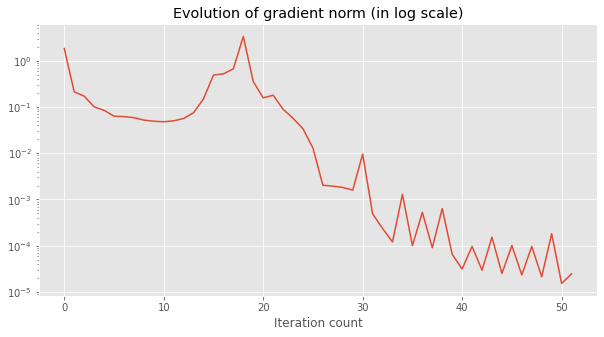

In [41]:
# Evolution of gradient norm
plt.figure(figsize=(10,5))
plt.plot(df_every['norms-ℓ_2'].to_numpy())
#plt.plot(df_every['norms-ℓ_1'].to_numpy())
#plt.plot(df_every['norms-max'].to_numpy())
plt.yscale('log')
#plt.xscale('log')
plt.title('Evolution of gradient norm (in log scale)')
plt.xlabel('Iteration count')
plt.show()

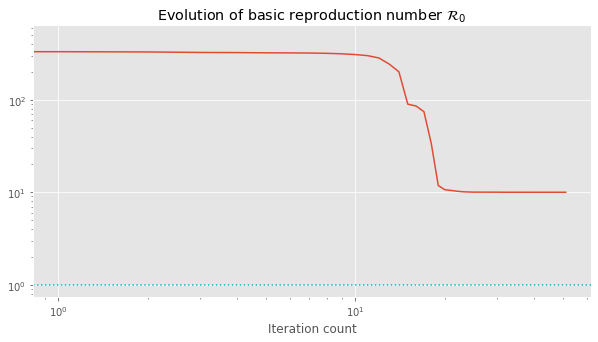

In [42]:
# Evolution of basic reproduction number
plt.figure(figsize=(10,5))
plt.plot(df_every['β'].to_numpy() * n / df_every['γ'].to_numpy())
plt.axhline(y=1, c='c', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of basic reproduction number $\mathcal{R}_0$')
plt.xlabel('Iteration count')
plt.show()

In [43]:
α̂ = df_every['β'][ argmin(df_every['obj']) ], df_every['γ'][ argmin(df_every['obj']) ]

β_its, γ_its = maximum(df_every['β'].to_numpy(), 0.0071), df_every['γ'].to_numpy()

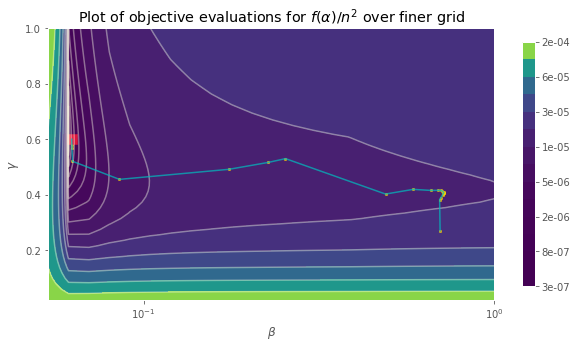

In [44]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
plt.xscale('symlog', linthresh = 3e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

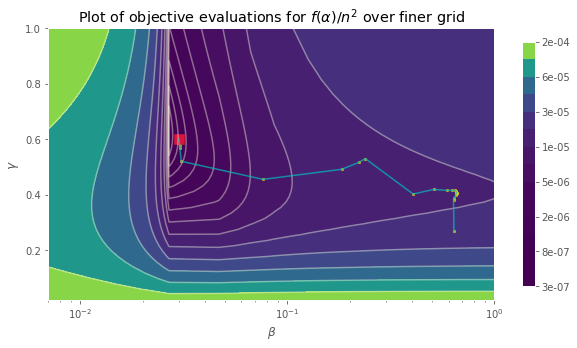

In [45]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

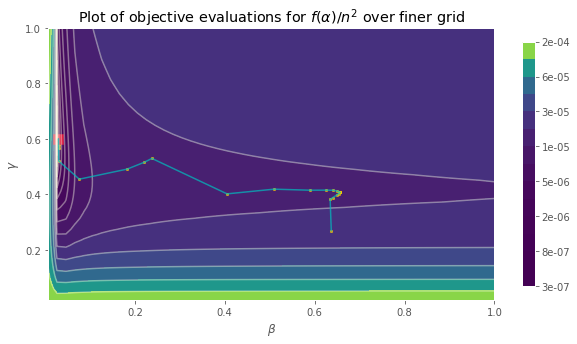

In [46]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

---

# Joint plots

In [24]:
BFGS_every  = pd.read_pickle('Outputs/Exact – LMBFGS - Every.pkl')
nmAPG_every = pd.read_pickle('Outputs/Exact – nmAPG - Every.pkl')
FISTA_every = pd.read_pickle('Outputs/Exact – FISTA - Every.pkl')
PGD_every   = pd.read_pickle('Outputs/Exact – PGD - Every.pkl')

In [25]:
PGD_every.tail()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
1694,1693,9.338234e-07,26.744332,0.029996,0.600977,0.002715,0.001922,0.002318,0.002352,0.002715,0.001922
1695,1694,9.312506e-07,26.756315,0.029995,0.600976,0.000897,0.001910,0.001404,0.001492,0.001910,0.000897
1696,1695,9.293673e-07,26.766338,0.029994,0.600975,0.000008,0.001902,0.000955,0.001345,0.001902,0.000008
1697,1696,1.183139e-07,26.787221,0.029990,0.599975,-0.023122,-0.000181,0.011652,0.016350,0.023122,0.000181
1698,1697,6.292543e-10,26.809558,0.030000,0.599975,-0.000371,-0.000051,0.000211,0.000265,0.000371,0.000051


In [26]:
FISTA_every.tail()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
358,357,0.000006,2.638405,0.029986,0.602517,-0.000027,0.004887,0.002457,0.003456,0.004887,0.000027
359,358,0.000006,2.644122,0.029986,0.602524,-0.000027,0.004900,0.002463,0.003465,0.004900,0.000027
360,359,0.000006,2.649841,0.029986,0.602529,-0.000026,0.004909,0.002468,0.003471,0.004909,0.000026
361,360,0.000006,2.655561,0.029986,0.602531,-0.000026,0.004913,0.002470,0.003474,0.004913,0.000026
362,361,0.000006,2.661289,0.029986,0.602531,-0.000027,0.004913,0.002470,0.003474,0.004913,0.000027


In [27]:
nmAPG_every.tail()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
290,290,4.980783542507488e-09,4.580678,0.030001,0.599929,0.000606,-0.000137,0.000371,0.000439,0.000606,0.000137
291,291,4.927240900547394e-09,4.608134,0.030000,0.599929,0.000120,-0.000142,0.000131,0.000131,0.000142,0.000120
292,292,5.0008056312502024e-09,4.631730,0.030000,0.599929,-0.000771,-0.000142,0.000457,0.000554,0.000771,0.000142
293,293,4.870036107332972e-09,4.660706,0.030000,0.599930,-0.000299,-0.000135,0.000217,0.000232,0.000299,0.000135
294,294,4.8857724090973656e-09,4.687041,0.030001,0.599930,0.000148,-0.000135,0.000142,0.000142,0.000148,0.000135


In [28]:
BFGS_every.tail()

,it,obj,time,β,γ,df_β,df_γ,t_k,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
47,46,2.6544453107904417e-10,7.336096,0.03,0.599984,0.000133,-0.000031,1.000000,0.000082,0.000097,0.000133,0.000031
48,47,2.3102349522305225e-10,7.369650,0.03,0.599985,-0.000002,-0.000030,0.999864,0.000016,0.000021,0.000030,0.000002
49,48,1.9228249014981917e-10,7.393346,0.03,0.599987,0.000256,-0.000025,1.000000,0.000140,0.000182,0.000256,0.000025
50,49,1.0464764499279939e-10,7.426414,0.03,0.599990,-0.000008,-0.000020,0.998939,0.000014,0.000015,0.000020,0.000008
51,50,1.0404906482486243e-10,7.607165,0.03,0.599990,0.000029,-0.000020,1.000000,0.000024,0.000025,0.000029,0.000020


In [34]:
from matplotlib   import colormaps
CMap = colormaps['YlGnBu']
colours_BFGS = CMap(linspace(0.3,1,14))

CMap = colormaps['YlOrBr']
colours_GD = CMap(linspace(0.3,1,14))

CMap = colormaps['RdPu']
colours_FISTA = CMap(linspace(0.3,1,14))

CMap = colormaps['BuGn']
colours_nmAPG = CMap(linspace(0.3,1,14))

In [35]:
# Best value LM BFGS
α̂_LM = BFGS_every['β'][ argmin(BFGS_every['obj']) ], BFGS_every['γ'][ argmin(BFGS_every['obj']) ]
β_LM, γ_LM = maximum(BFGS_every['β'].to_numpy(), 0.0071), BFGS_every['γ'].to_numpy()

# Best value FISTA
α̂_FISTA = FISTA_every['β'][ argmin(FISTA_every['obj']) ], FISTA_every['γ'][ argmin(FISTA_every['obj']) ]
β_FISTA, γ_FISTA = maximum(FISTA_every['β'].to_numpy(), 0.0071), FISTA_every['γ'].to_numpy()

# Best value nmAPG
α̂_nmAPG = nmAPG_every['β'][ argmin(nmAPG_every['obj']) ], nmAPG_every['γ'][ argmin(nmAPG_every['obj']) ]
β_nmAPG, γ_nmAPG = maximum(nmAPG_every['β'].to_numpy(), 0.0071), nmAPG_every['γ'].to_numpy()

# Best value PGD
α̂_PGD = PGD_every['β'][ argmin(PGD_every['obj']) ], PGD_every['γ'][ argmin(PGD_every['obj']) ]
β_PGD, γ_PGD = maximum(PGD_every['β'].to_numpy(), 0.0071), PGD_every['γ'].to_numpy()

In [48]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.007,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

Plot of objective evaluations for f(α)/n² over finer grid


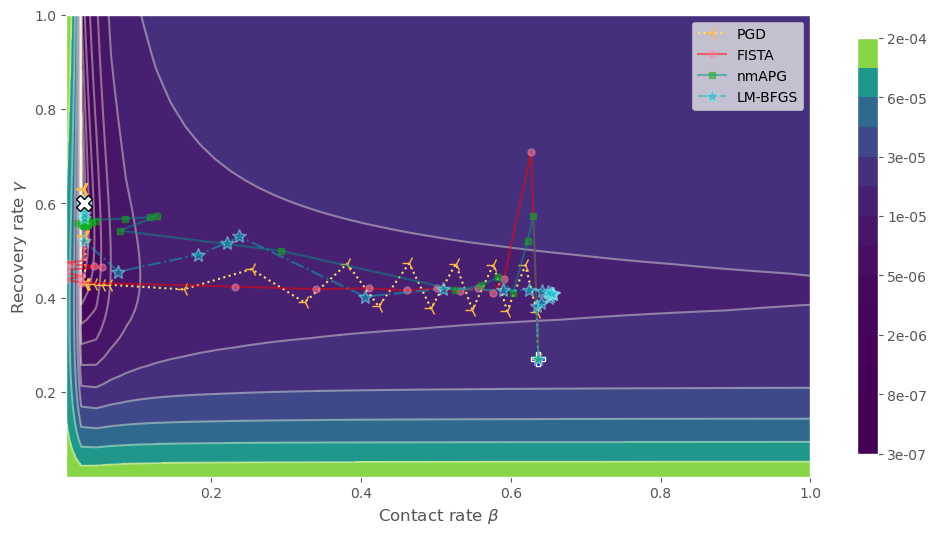

In [49]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')



# Starting point
plt.plot( β_LM[0], γ_LM[0], markersize=10, marker='P', color='white', markerfacecolor='b' )

# Optimisation path PGD
ℓ_PGD = 1660
plt.plot( β_PGD[:-ℓ_PGD], γ_PGD[:-ℓ_PGD], c='xkcd:pale gold', markeredgecolor = colours_GD[2],
         alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')

plt.plot( β_PGD[ ℓ_PGD:], γ_PGD[ ℓ_PGD:], c='gold', alpha=0.01, marker='3', linestyle = ':', markersize='4')

# Optimisation path FISTA
ℓ_FISTA = 20
plt.plot( β_FISTA[:ℓ_FISTA], γ_FISTA[:ℓ_FISTA], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='.', linestyle = '-', markersize='10', label='FISTA')
plt.plot( β_FISTA[ ℓ_FISTA-1:], γ_FISTA[ ℓ_FISTA-1:], c='r', markeredgecolor = 'xkcd:rosa',
         alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path nmAPG
ℓ_nmAPG = 30
plt.plot( β_nmAPG[:ℓ_nmAPG], γ_nmAPG[:ℓ_nmAPG], c='xkcd:teal', 
         markeredgecolor = 'xkcd:green', markerfacecolor = 'xkcd:green',
         alpha=0.5, marker='s', linestyle = '-', markersize='5', label='nmAPG')
plt.plot( β_nmAPG[ ℓ_nmAPG-1:], γ_nmAPG[ ℓ_nmAPG-1:], c='xkcd:teal', markeredgecolor = 'xkcd:green',
         alpha=0.5, marker='s',linestyle = '-',markersize='1')


# Optimisation path LM
plt.plot( β_LM, γ_LM, c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", #markerfacecolor = '#FFD300', 
         alpha=0.5, marker='*', linestyle = '-.', markersize=10, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=12, marker='X', markeredgecolor='black', color='white' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.legend()
plt.show()
fig.savefig('Outputs/Exact – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Compute finer mesh around optimal point:

In [50]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.028,0.032,nβ)
γ_axis = linspace(0.5,0.7,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

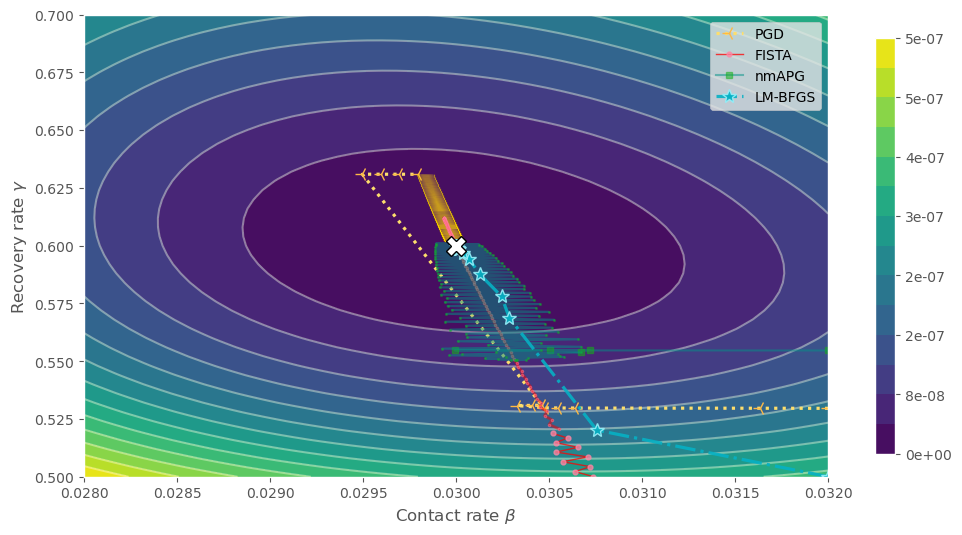

In [63]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
'''ℓ = np.logspace( np.log( Misfit[Misfit>0.0].min()/n**2 ), np.log( Misfit.max()/n**2 ), 
                num=15, endpoint=True, base=np.e)
'''
#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min



# Optimisation path PGD
ℓ_PGD = 21
h_PGD = 33
'''plt.plot( β_PGD[:-ℓ_PGD], γ_PGD[:-ℓ_PGD], c='xkcd:pale gold', markeredgecolor = 'gold',
         alpha=1, marker='3', linestyle = ':', markersize='10', label='PDG')'''
plt.plot( clip(β_PGD[ ℓ_PGD:h_PGD],0.02,0.032), clip(γ_PGD[ ℓ_PGD:h_PGD],0.5, 0.7), 
            c='xkcd:pale gold', markeredgecolor = colours_GD[2], #'gold', 
             linewidth=2.3,
                 alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ h_PGD-1:], γ_PGD[ h_PGD-1:], c='gold', alpha=0.7, marker='3', linestyle = '-', 
         markersize=0.1, linewidth=0.05)


# Optimisation path FISTA
ℓ_FISTA = 30
h_FISTA = 40
plt.plot( β_FISTA[ℓ_FISTA:h_FISTA], γ_FISTA[ℓ_FISTA:h_FISTA], c='r', 
             markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa', linewidth=1,
                 alpha=0.75, marker='.', linestyle = '-', markersize='7', label='FISTA')
plt.plot( β_FISTA[ h_FISTA:], γ_FISTA[ h_FISTA:], c='r', markeredgecolor = 'xkcd:rosa', linewidth=2,
             alpha=0.5, marker='.',linestyle = '-',markersize='3')

# Optimisation path nmAPG
h_nmAPG = 20
ℓ_nmAPG = 25
plt.plot( clip(β_nmAPG[h_nmAPG:ℓ_nmAPG],0.02,0.032), γ_nmAPG[h_nmAPG:ℓ_nmAPG], c='xkcd:teal', 
         markeredgecolor = 'xkcd:green', markerfacecolor = 'xkcd:green',
         alpha=0.5, marker='s', linestyle = '-', markersize='5', label='nmAPG')
plt.plot( β_nmAPG[ ℓ_nmAPG-1:], γ_nmAPG[ ℓ_nmAPG-1:], c='xkcd:teal', markeredgecolor = 'xkcd:green',
         alpha=0.5, marker='s',linestyle = '-',markersize='1')


# Optimisation path LM
ℓ_LM = 18
plt.plot( clip(β_LM[ℓ_LM:],0.02,0.032), clip(γ_LM[ℓ_LM:],0.5, 0.7), c='xkcd:turquoise blue', 
             markeredgecolor = "xkcd:robin's egg blue", #markerfacecolor = '#FFD300', 
             linewidth=2.3, alpha=0.9, marker='*', linestyle = '-.', markersize=10, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='X', markeredgecolor='black', color='white' )





fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
plt.legend()
plt.show()
fig.savefig('Outputs/Exact – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

In [64]:
# Minimal objective achieved:
Lowest = min(min(PGD_every['obj']), min(FISTA_every['obj']), min(nmAPG_every['obj']), min(BFGS_every['obj']))

Objective values per iteration


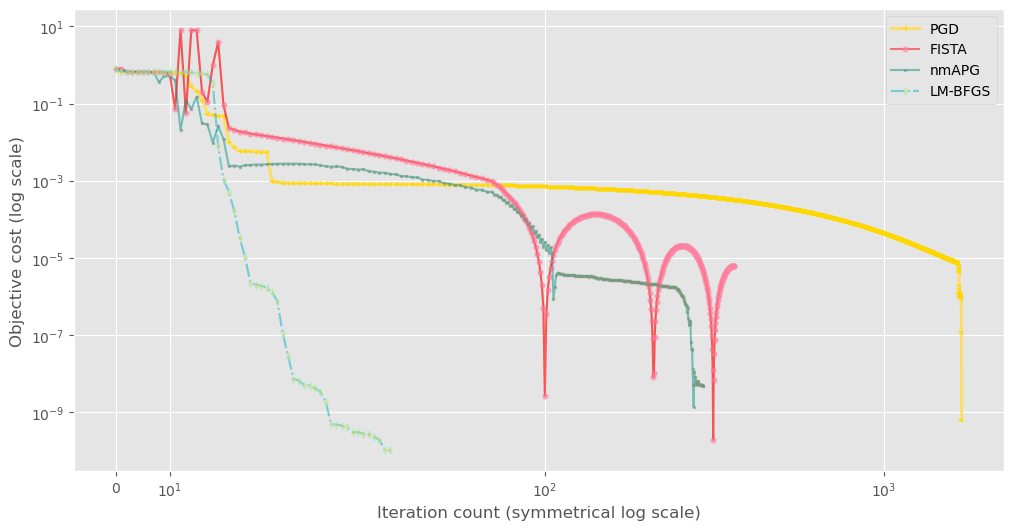

In [78]:
# Visualise evolution of objective values
plt.figure(figsize = (12,6))

plt.plot(PGD_every['obj'], c='xkcd:pale gold', markeredgecolor = 'gold', linewidth=2.3,
                 alpha=1, marker='3', linestyle = '-', markersize='4', label='PGD')
plt.plot(FISTA_every['obj'], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='.', linestyle = '-', markersize='7', label='FISTA')
plt.plot( nmAPG_every['obj'], c='xkcd:teal', 
         markeredgecolor = 'xkcd:gray', markerfacecolor = 'xkcd:green',
         alpha=0.5, marker='s', linestyle = '-', markersize='2', label='nmAPG')
plt.plot(FISTA_every['obj'], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.25, marker='.', linestyle = '-', markersize='5')
plt.plot( BFGS_every['obj'], c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', 
         alpha=0.5, marker='d', linestyle = '-.', markersize=4, label='LM-BFGS')

plt.yscale('log');    
plt.xscale('log');
#plt.title('Objective values per iteration')
print('Objective values per iteration')
plt.xlabel('Iteration count (symmetrical log scale)');    plt.ylabel('Objective cost (log scale)')
plt.xscale('symlog', linthresh = 7e1)

plt.legend()
##plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.savefig('Outputs/Exact – Objective.pdf', bbox_inches='tight', pad_inches=0,transparent=False)
plt.show()

Difference in norm of the best minimisers found:

In [59]:
norm(asarray(α̂_LM) - α̂_FISTA), norm(asarray(α̂_LM) - α̂_PGD), norm(asarray(α̂_PGD) - α̂_FISTA)

(3.737397114912371e-06, 1.4429498392717035e-05, 1.0692277219898467e-05)

In [72]:
norm(asarray(α̂_LM) - asarray([0.03,0.6])), norm(asarray([0.03,0.6]) - α̂_PGD), norm(asarray([0.03,0.6]) - α̂_FISTA)

(1.0294987231491072e-05, 2.4723935178705386e-05, 1.40323475084634e-05)

---